In [16]:
import h5py
import healpy as hp
import numpy as np
import os 
import yaml

import matplotlib
%matplotlib inline

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt

import sys
sys.path.append('../code')
import utils
import run_inference

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
dir_configs = '../configs/configs_inference/'
fn_config_inference = f'{dir_configs}/config_inference_seed42_ratioNgalNagn1_bgal1.0_bagn1.0_fagn1.0_lambdaagn0.0_grid_nH030_nalphaagn30.yaml'
print(fn_config_inference)

with open(fn_config_inference, 'r') as f:
    config_inference = yaml.safe_load(f)

config_data_path = config_inference['fn_config_data']
print(config_data_path)

with open(config_data_path, 'r') as f:
    config_data = yaml.safe_load(f)

../configs/configs_inference//config_inference_seed42_ratioNgalNagn1_bgal1.0_bagn1.0_fagn1.0_lambdaagn0.0_grid_nH030_nalphaagn30.yaml
../configs/configs_data/config_data_seed42_ratioNgalNagn1_bgal1.0_bagn1.0_fagn1.0_lambdaagn0.0.yaml


Loading likelihood grid from: ../results/inference/inference_results_seed42_ratioNgalNagn1_bgal1.0_bagn1.0_fagn1.0_lambdaagn0.0_grid_nH030_nalphaagn30.h5
Loading likelihood grid from ../results/inference/inference_results_seed42_ratioNgalNagn1_bgal1.0_bagn1.0_fagn1.0_lambdaagn0.0_grid_nH030_nalphaagn30.h5
Loaded likelihood grid with shape: (30, 30)
H0 grid: 30 points from 50.0 to 100.0
alpha_agn grid: 30 points from 0.000 to 1.000


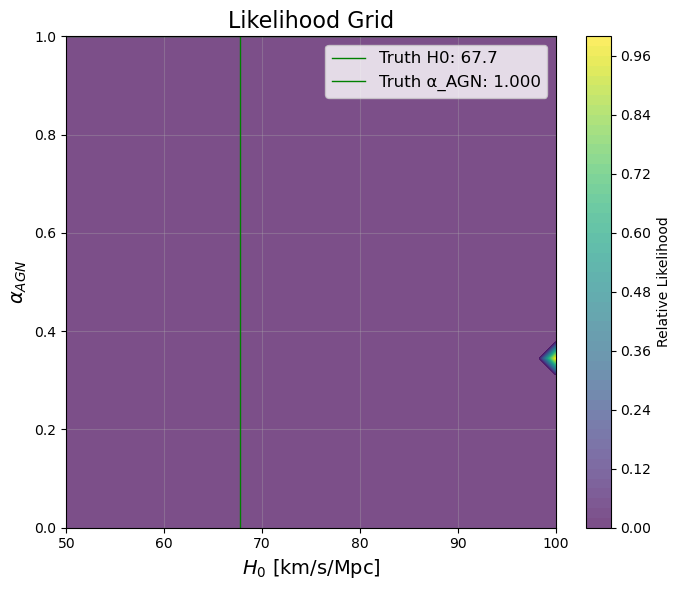

In [18]:
# Get output file from config
fn_inf = config_inference['paths']['fn_inf']

print(f"Loading likelihood grid from: {fn_inf}")

# Load likelihood grid
likelihood_results = run_inference.load_likelihood_grid(fn_inf)

# Extract data
log_likelihood_grid = likelihood_results['log_likelihood_grid']
H0_grid = likelihood_results['H0_grid']
alpha_agn_grid = likelihood_results['alpha_agn_grid']

print(f"Loaded likelihood grid with shape: {log_likelihood_grid.shape}")
print(f"H0 grid: {len(H0_grid)} points from {H0_grid.min():.1f} to {H0_grid.max():.1f}")
print(f"alpha_agn grid: {len(alpha_agn_grid)} points from {alpha_agn_grid.min():.3f} to {alpha_agn_grid.max():.3f}")

# Get truth values from config
truth_H0 = config_data['cosmology']['H0']
truth_f_agn = config_data['gw_injection']['f_agn']
truth_lambda_agn = config_data['gw_injection']['lambda_agn']

with h5py.File(f'{config_data['paths']['dir_mock']}/{config_data['paths']['name_cat']}', 'r') as f:
    N_gal_truth = f.attrs['n_gal']
    N_agn_truth = f.attrs['n_agn']

_, truth_alpha_agn = utils.compute_gw_host_fractions(N_gal_truth, N_agn_truth, truth_f_agn, lambda_agn=truth_lambda_agn)

# Create meshgrid for plotting
H0_mesh, alpha_agn_mesh = np.meshgrid(H0_grid, alpha_agn_grid)

# Plot likelihood grid as contour plot
fig, ax = plt.subplots(figsize=(7,6))

# Convert to likelihood (relative, normalized)
likelihood_grid = np.exp(log_likelihood_grid - np.nanmax(log_likelihood_grid))

# Fill contours
im = ax.contourf(H0_mesh, alpha_agn_mesh, likelihood_grid, levels=50, cmap='viridis', alpha=0.7)
plt.colorbar(im, ax=ax, label='Relative Likelihood')

# Add green truth lines
ax.axvline(truth_H0, color='green', linestyle='-', linewidth=1, label=f'Truth H0: {truth_H0:.1f}')
ax.axhline(truth_alpha_agn, color='green', linestyle='-', linewidth=1, label=f'Truth α_AGN: {truth_alpha_agn:.3f}')

ax.set_xlabel(r'$H_0$ [km/s/Mpc]', fontsize=14)
ax.set_ylabel(r'$\alpha_{AGN}$', fontsize=14)
ax.set_title(f'Likelihood Grid', fontsize=16)
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [4]:
dir_configs = '../configs/configs_inference/'
fn_config_inference = f'{dir_configs}/config_inference_seed42_ratioNgalNagn1_bgal1.0_bagn1.0_fagn0.5_lambdaagn0.0_grid_nH030_nalphaagn30.yaml'
print(fn_config_inference)

with open(fn_config_inference, 'r') as f:
    config_inference = yaml.safe_load(f)

config_data_path = config_inference['fn_config_data']
print(config_data_path)

with open(config_data_path, 'r') as f:
    config_data = yaml.safe_load(f)

../configs/configs_inference//config_inference_seed42_ratioNgalNagn1_bgal1.0_bagn1.0_fagn0.5_lambdaagn0.0_grid_nH030_nalphaagn30.yaml
../configs/configs_data/config_data_seed42_ratioNgalNagn1_bgal1.0_bagn1.0_fagn0.5_lambdaagn0.0.yaml


Loading likelihood grid from: ../results/inference/inference_results_seed42_ratioNgalNagn1_bgal1.0_bagn1.0_fagn0.5_lambdaagn0.0_grid_nH030_nalphaagn30.h5
Loading likelihood grid from ../results/inference/inference_results_seed42_ratioNgalNagn1_bgal1.0_bagn1.0_fagn0.5_lambdaagn0.0_grid_nH030_nalphaagn30.h5
Loaded likelihood grid with shape: (30, 30)
H0 grid: 30 points from 50.0 to 100.0
alpha_agn grid: 30 points from 0.000 to 1.000

Truth values (from config):
  H0: 67.74 km/s/Mpc
  alpha_agn: 0.500


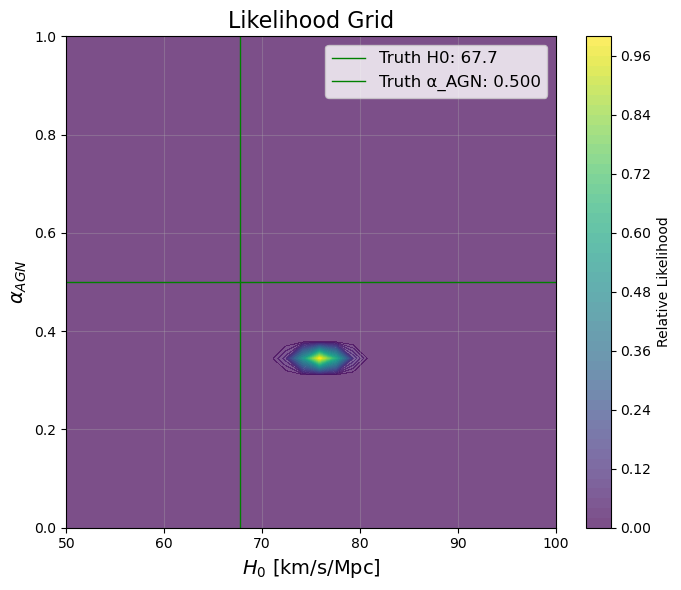

In [ ]:
# Get output file from config
fn_inf = config_inference['paths']['fn_inf']

print(f"Loading likelihood grid from: {fn_inf}")

# Load likelihood grid
likelihood_results = run_inference.load_likelihood_grid(fn_inf)

# Extract data
log_likelihood_grid = likelihood_results['log_likelihood_grid']
H0_grid = likelihood_results['H0_grid']
alpha_agn_grid = likelihood_results['alpha_agn_grid']

print(f"Loaded likelihood grid with shape: {log_likelihood_grid.shape}")
print(f"H0 grid: {len(H0_grid)} points from {H0_grid.min():.1f} to {H0_grid.max():.1f}")
print(f"alpha_agn grid: {len(alpha_agn_grid)} points from {alpha_agn_grid.min():.3f} to {alpha_agn_grid.max():.3f}")

# Get truth values from config
truth_H0 = config_data['cosmology']['H0']
truth_f_agn = config_data['gw_injection']['f_agn']
truth_lambda_agn = config_data['gw_injection']['lambda_agn']

with h5py.File(f'{config_data['paths']['dir_mock']}/{config_data['paths']['name_cat']}', 'r') as f:
    N_gal_truth = f.attrs['n_gal']
    N_agn_truth = f.attrs['n_agn']

_, truth_alpha_agn = utils.compute_gw_host_fractions(N_gal_truth, N_agn_truth, truth_f_agn, lambda_agn=truth_lambda_agn)

# Create meshgrid for plotting
H0_mesh, alpha_agn_mesh = np.meshgrid(H0_grid, alpha_agn_grid)

# Plot likelihood grid as contour plot
fig, ax = plt.subplots(figsize=(7,6))

# Convert to likelihood (relative, normalized)
likelihood_grid = np.exp(log_likelihood_grid - np.nanmax(log_likelihood_grid))

# Fill contours
im = ax.contourf(H0_mesh, alpha_agn_mesh, likelihood_grid, levels=50, cmap='viridis', alpha=0.7)
plt.colorbar(im, ax=ax, label='Relative Likelihood')

# Add green truth lines
ax.axvline(truth_H0, color='green', linestyle='-', linewidth=1, label=f'Truth H0: {truth_H0:.1f}')
ax.axhline(truth_alpha_agn, color='green', linestyle='-', linewidth=1, label=f'Truth α_AGN: {truth_alpha_agn:.3f}')

ax.set_xlabel(r'$H_0$ [km/s/Mpc]', fontsize=14)
ax.set_ylabel(r'$\alpha_{AGN}$', fontsize=14)
ax.set_title(f'Likelihood Grid', fontsize=16)
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [22]:
dir_configs = '../configs/configs_inference/'
fn_config_inference = f'{dir_configs}/config_inference_seed42_ratioNgalNagn1_bgal1.0_bagn1.0_fagn0.5_lambdaagn0.0_grid_nH030_nalphaagn30.yaml'
print(fn_config_inference)

with open(fn_config_inference, 'r') as f:
    config_inference = yaml.safe_load(f)

config_data_path = config_inference['fn_config_data']
print(config_data_path)

with open(config_data_path, 'r') as f:
    config_data = yaml.safe_load(f)

../configs/configs_inference//config_inference_seed42_ratioNgalNagn1_bgal1.0_bagn1.0_fagn0.5_lambdaagn0.0_grid_nH030_nalphaagn30.yaml
../configs/configs_data/config_data_seed42_ratioNgalNagn1_bgal1.0_bagn1.0_fagn0.5_lambdaagn0.0.yaml


Loading likelihood grid from: ../results/inference/inference_results_seed42_ratioNgalNagn1_bgal1.0_bagn1.0_fagn0.5_lambdaagn0.0_grid_nH030_nalphaagn30.h5
Loading likelihood grid from ../results/inference/inference_results_seed42_ratioNgalNagn1_bgal1.0_bagn1.0_fagn0.5_lambdaagn0.0_grid_nH030_nalphaagn30.h5
Loaded likelihood grid with shape: (30, 30)
H0 grid: 30 points from 50.0 to 100.0
alpha_agn grid: 30 points from 0.000 to 1.000


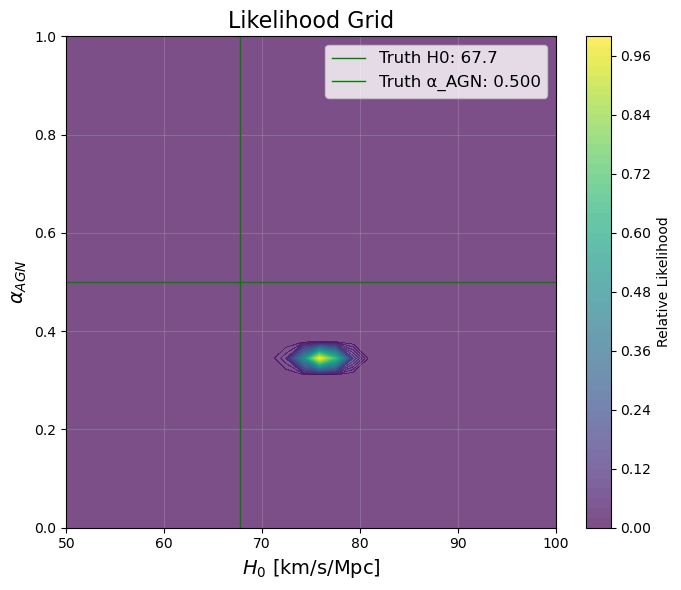

In [23]:
# Get output file from config
fn_inf = config_inference['paths']['fn_inf']

print(f"Loading likelihood grid from: {fn_inf}")

# Load likelihood grid
likelihood_results = run_inference.load_likelihood_grid(fn_inf)

# Extract data
log_likelihood_grid = likelihood_results['log_likelihood_grid']
H0_grid = likelihood_results['H0_grid']
alpha_agn_grid = likelihood_results['alpha_agn_grid']

print(f"Loaded likelihood grid with shape: {log_likelihood_grid.shape}")
print(f"H0 grid: {len(H0_grid)} points from {H0_grid.min():.1f} to {H0_grid.max():.1f}")
print(f"alpha_agn grid: {len(alpha_agn_grid)} points from {alpha_agn_grid.min():.3f} to {alpha_agn_grid.max():.3f}")

# Get truth values from config
truth_H0 = config_data['cosmology']['H0']
truth_f_agn = config_data['gw_injection']['f_agn']
truth_lambda_agn = config_data['gw_injection']['lambda_agn']

with h5py.File(f'{config_data['paths']['dir_mock']}/{config_data['paths']['name_cat']}', 'r') as f:
    N_gal_truth = f.attrs['n_gal']
    N_agn_truth = f.attrs['n_agn']

_, truth_alpha_agn = utils.compute_gw_host_fractions(N_gal_truth, N_agn_truth, truth_f_agn, lambda_agn=truth_lambda_agn)

# Create meshgrid for plotting
H0_mesh, alpha_agn_mesh = np.meshgrid(H0_grid, alpha_agn_grid)

# Plot likelihood grid as contour plot
fig, ax = plt.subplots(figsize=(7,6))

# Convert to likelihood (relative, normalized)
likelihood_grid = np.exp(log_likelihood_grid - np.nanmax(log_likelihood_grid))

# Fill contours
im = ax.contourf(H0_mesh, alpha_agn_mesh, likelihood_grid, levels=50, cmap='viridis', alpha=0.7)
plt.colorbar(im, ax=ax, label='Relative Likelihood')

# Add green truth lines
ax.axvline(truth_H0, color='green', linestyle='-', linewidth=1, label=f'Truth H0: {truth_H0:.1f}')
ax.axhline(truth_alpha_agn, color='green', linestyle='-', linewidth=1, label=f'Truth α_AGN: {truth_alpha_agn:.3f}')

ax.set_xlabel(r'$H_0$ [km/s/Mpc]', fontsize=14)
ax.set_ylabel(r'$\alpha_{AGN}$', fontsize=14)
ax.set_title(f'Likelihood Grid', fontsize=16)
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
dir_configs = '../configs/configs_inference/'
fn_config_inference = f'{dir_configs}/config_inference_seed42_ratioNgalNagn1_bgal1.0_bagn1.0_fagn0.25_lambdaagn0.0_grid_nH030_nalphaagn30.yaml'
print(fn_config_inference)

with open(fn_config_inference, 'r') as f:
    config_inference = yaml.safe_load(f)

config_data_path = config_inference['fn_config_data']
print(config_data_path)

with open(config_data_path, 'r') as f:
    config_data = yaml.safe_load(f)a

../configs/configs_inference//config_inference_seed42_ratioNgalNagn1_bgal1.0_bagn1.0_fagn0.25_lambdaagn0.0_grid_nH030_nalphaagn30.yaml
../configs/configs_data/config_data_seed42_ratioNgalNagn1_bgal1.0_bagn1.0_fagn0.25_lambdaagn0.0.yaml


Loading likelihood grid from: ../results/inference/inference_results_seed42_ratioNgalNagn1_bgal1.0_bagn1.0_fagn0.25_lambdaagn0.0_grid_nH030_nalphaagn30.h5
Loading likelihood grid from ../results/inference/inference_results_seed42_ratioNgalNagn1_bgal1.0_bagn1.0_fagn0.25_lambdaagn0.0_grid_nH030_nalphaagn30.h5
Loaded likelihood grid with shape: (30, 30)
H0 grid: 30 points from 50.0 to 100.0
alpha_agn grid: 30 points from 0.000 to 1.000


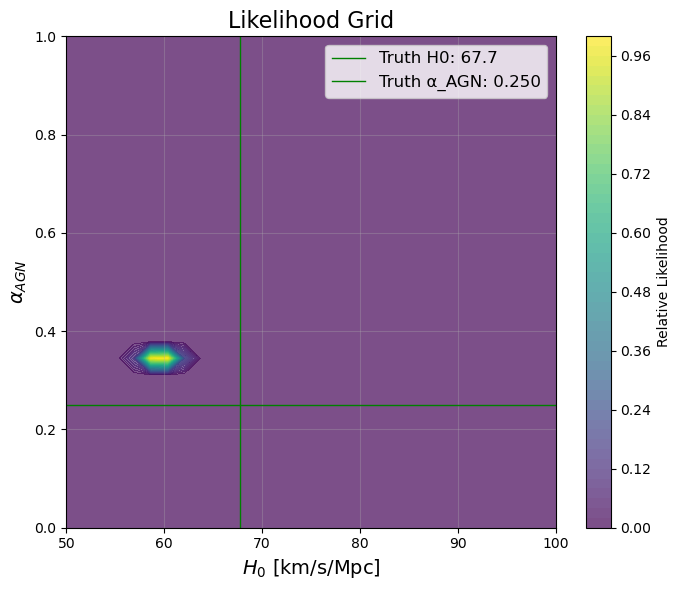

In [11]:
# Get output file from config
fn_inf = config_inference['paths']['fn_inf']

print(f"Loading likelihood grid from: {fn_inf}")

# Load likelihood grid
likelihood_results = run_inference.load_likelihood_grid(fn_inf)

# Extract data
log_likelihood_grid = likelihood_results['log_likelihood_grid']
H0_grid = likelihood_results['H0_grid']
alpha_agn_grid = likelihood_results['alpha_agn_grid']

print(f"Loaded likelihood grid with shape: {log_likelihood_grid.shape}")
print(f"H0 grid: {len(H0_grid)} points from {H0_grid.min():.1f} to {H0_grid.max():.1f}")
print(f"alpha_agn grid: {len(alpha_agn_grid)} points from {alpha_agn_grid.min():.3f} to {alpha_agn_grid.max():.3f}")

# Get truth values from config
truth_H0 = config_data['cosmology']['H0']
truth_f_agn = config_data['gw_injection']['f_agn']
truth_lambda_agn = config_data['gw_injection']['lambda_agn']

with h5py.File(f'{config_data['paths']['dir_mock']}/{config_data['paths']['name_cat']}', 'r') as f:
    N_gal_truth = f.attrs['n_gal']
    N_agn_truth = f.attrs['n_agn']

_, truth_alpha_agn = utils.compute_gw_host_fractions(N_gal_truth, N_agn_truth, truth_f_agn, lambda_agn=truth_lambda_agn)

# Create meshgrid for plotting
H0_mesh, alpha_agn_mesh = np.meshgrid(H0_grid, alpha_agn_grid)

# Plot likelihood grid as contour plot
fig, ax = plt.subplots(figsize=(7,6))

# Convert to likelihood (relative, normalized)
likelihood_grid = np.exp(log_likelihood_grid - np.nanmax(log_likelihood_grid))

# Fill contours
im = ax.contourf(H0_mesh, alpha_agn_mesh, likelihood_grid, levels=50, cmap='viridis', alpha=0.7)
plt.colorbar(im, ax=ax, label='Relative Likelihood')

# Add green truth lines
ax.axvline(truth_H0, color='green', linestyle='-', linewidth=1, label=f'Truth H0: {truth_H0:.1f}')
ax.axhline(truth_alpha_agn, color='green', linestyle='-', linewidth=1, label=f'Truth α_AGN: {truth_alpha_agn:.3f}')

ax.set_xlabel(r'$H_0$ [km/s/Mpc]', fontsize=14)
ax.set_ylabel(r'$\alpha_{AGN}$', fontsize=14)
ax.set_title(f'Likelihood Grid', fontsize=16)
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [12]:
dir_configs = '../configs/configs_inference/'
fn_config_inference = f'{dir_configs}/config_inference_seed42_ratioNgalNagn1_bgal1.0_bagn1.0_fagn0.0_lambdaagn0.0_grid_nH030_nalphaagn30.yaml'
print(fn_config_inference)

with open(fn_config_inference, 'r') as f:
    config_inference = yaml.safe_load(f)

config_data_path = config_inference['fn_config_data']
print(config_data_path)

with open(config_data_path, 'r') as f:
    config_data = yaml.safe_load(f)

../configs/configs_inference//config_inference_seed42_ratioNgalNagn1_bgal1.0_bagn1.0_fagn0.0_lambdaagn0.0_grid_nH030_nalphaagn30.yaml
../configs/configs_data/config_data_seed42_ratioNgalNagn1_bgal1.0_bagn1.0_fagn0.0_lambdaagn0.0.yaml


Loading likelihood grid from: ../results/inference/inference_results_seed42_ratioNgalNagn1_bgal1.0_bagn1.0_fagn0.0_lambdaagn0.0_grid_nH030_nalphaagn30.h5
Loading likelihood grid from ../results/inference/inference_results_seed42_ratioNgalNagn1_bgal1.0_bagn1.0_fagn0.0_lambdaagn0.0_grid_nH030_nalphaagn30.h5
Loaded likelihood grid with shape: (30, 30)
H0 grid: 30 points from 50.0 to 100.0
alpha_agn grid: 30 points from 0.000 to 1.000


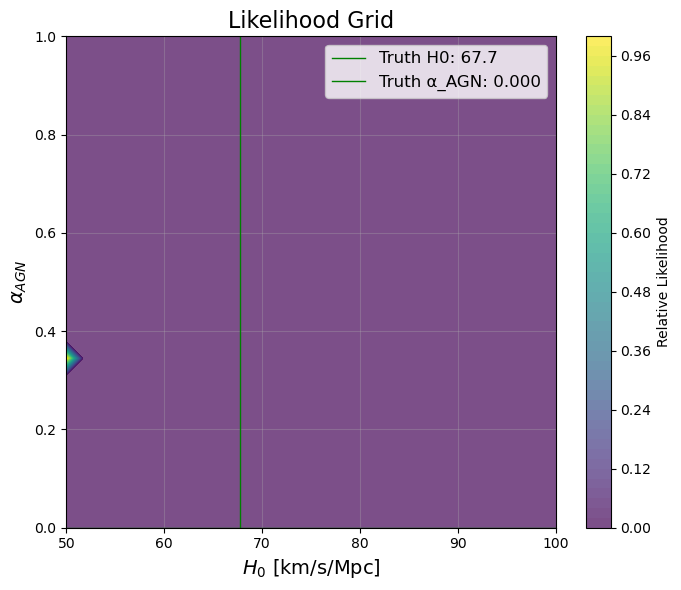

In [13]:
# Get output file from config
fn_inf = config_inference['paths']['fn_inf']

print(f"Loading likelihood grid from: {fn_inf}")

# Load likelihood grid
likelihood_results = run_inference.load_likelihood_grid(fn_inf)

# Extract data
log_likelihood_grid = likelihood_results['log_likelihood_grid']
H0_grid = likelihood_results['H0_grid']
alpha_agn_grid = likelihood_results['alpha_agn_grid']

print(f"Loaded likelihood grid with shape: {log_likelihood_grid.shape}")
print(f"H0 grid: {len(H0_grid)} points from {H0_grid.min():.1f} to {H0_grid.max():.1f}")
print(f"alpha_agn grid: {len(alpha_agn_grid)} points from {alpha_agn_grid.min():.3f} to {alpha_agn_grid.max():.3f}")

# Get truth values from config
truth_H0 = config_data['cosmology']['H0']
truth_f_agn = config_data['gw_injection']['f_agn']
truth_lambda_agn = config_data['gw_injection']['lambda_agn']

with h5py.File(f'{config_data['paths']['dir_mock']}/{config_data['paths']['name_cat']}', 'r') as f:
    N_gal_truth = f.attrs['n_gal']
    N_agn_truth = f.attrs['n_agn']

_, truth_alpha_agn = utils.compute_gw_host_fractions(N_gal_truth, N_agn_truth, truth_f_agn, lambda_agn=truth_lambda_agn)

# Create meshgrid for plotting
H0_mesh, alpha_agn_mesh = np.meshgrid(H0_grid, alpha_agn_grid)

# Plot likelihood grid as contour plot
fig, ax = plt.subplots(figsize=(7,6))

# Convert to likelihood (relative, normalized)
likelihood_grid = np.exp(log_likelihood_grid - np.nanmax(log_likelihood_grid))

# Fill contours
im = ax.contourf(H0_mesh, alpha_agn_mesh, likelihood_grid, levels=50, cmap='viridis', alpha=0.7)
plt.colorbar(im, ax=ax, label='Relative Likelihood')

# Add green truth lines
ax.axvline(truth_H0, color='green', linestyle='-', linewidth=1, label=f'Truth H0: {truth_H0:.1f}')
ax.axhline(truth_alpha_agn, color='green', linestyle='-', linewidth=1, label=f'Truth α_AGN: {truth_alpha_agn:.3f}')

ax.set_xlabel(r'$H_0$ [km/s/Mpc]', fontsize=14)
ax.set_ylabel(r'$\alpha_{AGN}$', fontsize=14)
ax.set_title(f'Likelihood Grid', fontsize=16)
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [19]:
dir_configs = '../configs/configs_inference/'
fn_config_inference = f'{dir_configs}/config_inference_seed42_ratioNgalNagn1_bgal1.0_bagn1.0_fagn0.5_lambdaagn0.5_grid_nH030_nalphaagn30.yaml'
print(fn_config_inference)

with open(fn_config_inference, 'r') as f:
    config_inference = yaml.safe_load(f)

config_data_path = config_inference['fn_config_data']
print(config_data_path)

with open(config_data_path, 'r') as f:
    config_data = yaml.safe_load(f)

../configs/configs_inference//config_inference_seed42_ratioNgalNagn1_bgal1.0_bagn1.0_fagn0.5_lambdaagn0.5_grid_nH030_nalphaagn30.yaml
../configs/configs_data/config_data_seed42_ratioNgalNagn1_bgal1.0_bagn1.0_fagn0.5_lambdaagn0.5.yaml


Loading likelihood grid from: ../results/inference/inference_results_seed42_ratioNgalNagn1_bgal1.0_bagn1.0_fagn0.5_lambdaagn0.5_grid_nH030_nalphaagn30.h5
Loading likelihood grid from ../results/inference/inference_results_seed42_ratioNgalNagn1_bgal1.0_bagn1.0_fagn0.5_lambdaagn0.5_grid_nH030_nalphaagn30.h5
Loaded likelihood grid with shape: (30, 30)
H0 grid: 30 points from 50.0 to 100.0
alpha_agn grid: 30 points from 0.000 to 1.000


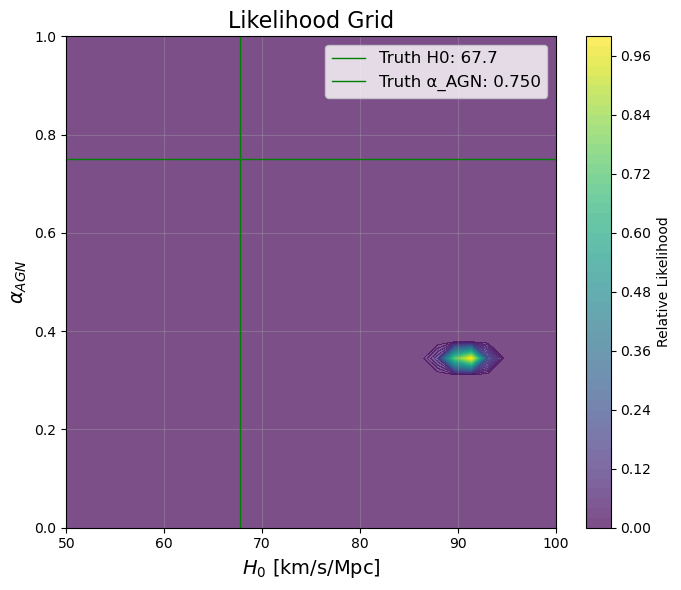

In [21]:
# Get output file from config
fn_inf = config_inference['paths']['fn_inf']

print(f"Loading likelihood grid from: {fn_inf}")

# Load likelihood grid
likelihood_results = run_inference.load_likelihood_grid(fn_inf)

# Extract data
log_likelihood_grid = likelihood_results['log_likelihood_grid']
H0_grid = likelihood_results['H0_grid']
alpha_agn_grid = likelihood_results['alpha_agn_grid']

print(f"Loaded likelihood grid with shape: {log_likelihood_grid.shape}")
print(f"H0 grid: {len(H0_grid)} points from {H0_grid.min():.1f} to {H0_grid.max():.1f}")
print(f"alpha_agn grid: {len(alpha_agn_grid)} points from {alpha_agn_grid.min():.3f} to {alpha_agn_grid.max():.3f}")

# Get truth values from config
truth_H0 = config_data['cosmology']['H0']
truth_f_agn = config_data['gw_injection']['f_agn']
truth_lambda_agn = config_data['gw_injection']['lambda_agn']

with h5py.File(f'{config_data['paths']['dir_mock']}/{config_data['paths']['name_cat']}', 'r') as f:
    N_gal_truth = f.attrs['n_gal']
    N_agn_truth = f.attrs['n_agn']

_, truth_alpha_agn = utils.compute_gw_host_fractions(N_gal_truth, N_agn_truth, truth_f_agn, lambda_agn=truth_lambda_agn)

# Create meshgrid for plotting
H0_mesh, alpha_agn_mesh = np.meshgrid(H0_grid, alpha_agn_grid)

# Plot likelihood grid as contour plot
fig, ax = plt.subplots(figsize=(7,6))

# Convert to likelihood (relative, normalized)
likelihood_grid = np.exp(log_likelihood_grid - np.nanmax(log_likelihood_grid))

# Fill contours
im = ax.contourf(H0_mesh, alpha_agn_mesh, likelihood_grid, levels=50, cmap='viridis', alpha=0.7)
plt.colorbar(im, ax=ax, label='Relative Likelihood')

# Add green truth lines
ax.axvline(truth_H0, color='green', linestyle='-', linewidth=1, label=f'Truth H0: {truth_H0:.1f}')
ax.axhline(truth_alpha_agn, color='green', linestyle='-', linewidth=1, label=f'Truth α_AGN: {truth_alpha_agn:.3f}')

ax.set_xlabel(r'$H_0$ [km/s/Mpc]', fontsize=14)
ax.set_ylabel(r'$\alpha_{AGN}$', fontsize=14)
ax.set_title(f'Likelihood Grid', fontsize=16)
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Check gw samples

In [46]:
# Settings for plotting
n_events_plot = 1000  # Number of events to plot (None for all)
n_samples_per_event = 100  # Number of samples per event to plot (None for all)

print(f"Plotting settings:")
print(f"  n_events: {n_events_plot if n_events_plot is not None else 'all'}")
print(f"  n_samples_per_event: {n_samples_per_event if n_samples_per_event is not None else 'all'}")

Plotting settings:
  n_events: 1000
  n_samples_per_event: 100


In [47]:
# Load GW samples from gwsamples file
import generate_gwsamples

# Get GW file path directly from config
dir_mock = '../data/mocks_glass/mock_seed42_ratioNgalNagn1_bgal1.0_bagn1.0'
fn_gw = f'{dir_mock}/gwsamples_fagn0.5_lambdaagn0.0.h5'

print(f"Loading GW samples from: {fn_gw}")

# Load GW samples (returns separate arrays for galaxies and AGNs)
ra_gal_samples, dec_gal_samples, dL_gal, _, _, \
ra_agn_samples, dec_agn_samples, dL_agn, _, _ = generate_gwsamples.load_samples(
    fn_gw, N_samples_gw=n_samples_per_event
)

# Concatenate galaxies and AGNs (galaxies first, then AGNs - no shuffling)
ra_samples = np.concatenate([ra_gal_samples, ra_agn_samples], axis=0)
dec_samples = np.concatenate([dec_gal_samples, dec_agn_samples], axis=0)

# Select number of events if specified
if n_events_plot is not None:
    ra_samples = ra_samples[:n_events_plot]
    dec_samples = dec_samples[:n_events_plot]

print(f"Loaded {len(ra_samples)} GW events with samples")
print(f"  Samples shape per event: {ra_samples.shape[1] if ra_samples.ndim == 2 else 'N/A'}")
print(f"  RA range: [{np.degrees(ra_samples.min()):.1f}°, {np.degrees(ra_samples.max()):.1f}°]")
print(f"  Dec range: [{np.degrees(dec_samples.min()):.1f}°, {np.degrees(dec_samples.max()):.1f}°]")

Loading GW samples from: ../data/mocks_glass/mock_seed42_ratioNgalNagn1_bgal1.0_bagn1.0/gwsamples_fagn0.5_lambdaagn0.0.h5
Loading GW samples from ../data/mocks_glass/mock_seed42_ratioNgalNagn1_bgal1.0_bagn1.0/gwsamples_fagn0.5_lambdaagn0.0.h5 (N_samples_gw=100)
Loaded 1000 GW events with samples
  Samples shape per event: 100
  RA range: [0.0°, 360.0°]
  Dec range: [-85.8°, 87.7°]


In [48]:
# Load true injected GW event positions from mock catalog
# Get file paths directly from config
fn_cat = os.path.join(dir_mock, config_data['paths']['name_cat'])
fn_gw_indices = os.path.join(dir_mock, config_data['paths']['name_gw'])

print(f"Loading true injected positions from:")
print(f"  Mock catalog: {fn_cat}")
print(f"  GW indices: {fn_gw_indices}")

# Load mock catalog
with h5py.File(fn_cat, 'r') as f:
    ra_gal_all = np.asarray(f['ra_gal']) * np.pi / 180  # Convert to radians
    dec_gal_all = np.asarray(f['dec_gal']) * np.pi / 180
    ra_agn_all = np.asarray(f['ra_agn']) * np.pi / 180
    dec_agn_all = np.asarray(f['dec_agn']) * np.pi / 180

# Load GW indices
with h5py.File(fn_gw_indices, 'r') as f:
    i_gw_gal = np.asarray(f['i_gw_gal'])
    i_gw_agn = np.asarray(f['i_gw_agn'])

# Extract true injected positions
ra_gal_events = ra_gal_all[i_gw_gal]
dec_gal_events = dec_gal_all[i_gw_gal]
ra_agn_events = ra_agn_all[i_gw_agn]
dec_agn_events = dec_agn_all[i_gw_agn]

# Combine all true injected positions (galaxies first, then AGNs, matching samples order)
ra_events = np.concatenate([ra_gal_events, ra_agn_events])
dec_events = np.concatenate([dec_gal_events, dec_agn_events])

# Select number of events if specified (must match samples selection)
if n_events_plot is not None:
    ra_events = ra_events[:n_events_plot]
    dec_events = dec_events[:n_events_plot]

print(f"Loaded {len(ra_events)} true injected GW event positions")

Loading true injected positions from:
  Mock catalog: ../data/mocks_glass/mock_seed42_ratioNgalNagn1_bgal1.0_bagn1.0/mock_catalog.h5
  GW indices: ../data/mocks_glass/mock_seed42_ratioNgalNagn1_bgal1.0_bagn1.0/gws_fagn0.5_lambdaagn0.0.h5
Loaded 1000 true injected GW event positions


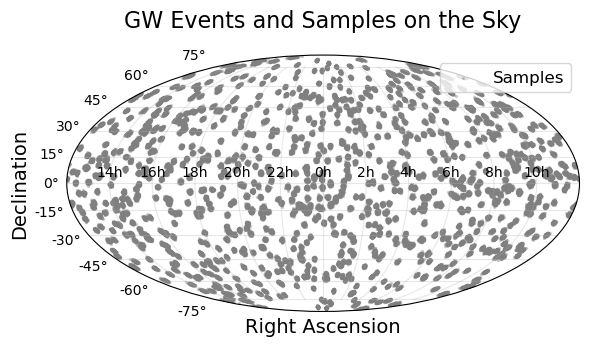

In [49]:
# Prepare data for plotting
# Flatten samples to 1D array for plotting
if ra_samples.ndim == 2:
    ra_all_samples = ra_samples.flatten()
    dec_all_samples = dec_samples.flatten()
else:
    ra_all_samples = ra_samples
    dec_all_samples = dec_samples

# Convert RA from [0, 2π] to [-π, π] for Mollweide projection
ra_events_plot = np.where(ra_events > np.pi, ra_events - 2*np.pi, ra_events)
ra_all_samples_plot = np.where(ra_all_samples > np.pi, ra_all_samples - 2*np.pi, ra_all_samples)

# Plot scatter plot of GW events and samples on the sky with Mollweide projection
figsize = (6, 4)
fig, ax = plt.subplots(figsize=figsize, subplot_kw={'projection': 'mollweide'})

# Plot all samples as small points
ax.scatter(ra_all_samples_plot, dec_all_samples, c='gray', s=2, alpha=0.3, 
           label='Samples', rasterized=True)

# Plot GW events as big stars
# ax.scatter(ra_events_plot, dec_events, c='magenta', s=20, marker='*', 
#            edgecolors=None, linewidths=0.5, label='GW Events', zorder=10)

ax.set_xlabel('Right Ascension', fontsize=14)
ax.set_ylabel('Declination', fontsize=14)
ax.set_title('GW Events and Samples on the Sky', fontsize=16, pad=20)
ax.legend(fontsize=12, loc='upper right')
ax.grid(True, alpha=0.3)

# Set tick labels to show hours
ax.set_xticklabels(['14h', '16h', '18h', '20h', '22h', '0h', '2h', '4h', '6h', '8h', '10h'])

plt.tight_layout()
plt.show()

## old

In [37]:
import astropy.units as u

def load_gw_samples(filename, nEvents=1000, nsamp=None):
    """
    Load gravitational wave samples from HDF5 file.
    
    Parameters
    ----------
    filename : str
        Path to GW samples HDF5 file
    nEvents : int, optional
        Number of events to use (default: all)
    nsamp : int, optional
        Number of samples per event to use (default: all)
    
    Returns
    -------
    dict
        Dictionary containing:
        - ra: right ascension samples
        - dec: declination samples
        - dL: luminosity distance samples
        - p_pe: prior probability for each sample
        - nEvents: number of events
        - nsamp: number of samples per event
    """
    print(f"Loading GW samples from {filename} (nEvents={nEvents}, nsamp={nsamp})")
    with h5py.File(filename, 'r') as inp:
        nsamp_ = inp.attrs['nsamp']
        nEvents_ = inp.attrs['nobs']
        # Read as 2D arrays with shape (nEvents_, nsamp_)
        ra = np.array(inp['ra'])  # Shape: (nEvents_, nsamp_)
        dec = np.array(inp['dec'])  # Shape: (nEvents_, nsamp_)
        dL = np.array((np.array(inp['dL']) * u.Mpc).value)  # Shape: (nEvents_, nsamp_)
        m1det = np.array(inp['m1det'])  # Shape: (nEvents_, nsamp_)
        m2det = np.array(inp['m2det'])  # Shape: (nEvents_, nsamp_)

    return ra, dec, dL, m1det, m2det
    
    # if nsamp is None:
    #     nsamp = nsamp_
    # if nEvents is None:
    #     nEvents = nEvents_
    
    # # Slice to requested number of events and samples, then flatten to 1D
    # ra = ra[0:nEvents, 0:nsamp].flatten()
    # dec = dec[0:nEvents, 0:nsamp].flatten()
    # dL = dL[0:nEvents, 0:nsamp].flatten()
    
    # p_pe = np.ones(len(dL))
    
    # return {
    #     'ra': ra,
    #     'dec': dec,
    #     'dL': dL,
    #     'p_pe': p_pe,
    #     'nEvents': nEvents,
    #     'nsamp': nsamp
    # }

In [ ]:
# Settings for plotting
n_events_plot = 1000  # Number of events to plot (None for all)
n_samples_per_event = 100  # Number of samples per event to plot (None for all)

print(f"Plotting settings:")
print(f"  n_events: {n_events_plot if n_events_plot is not None else 'all'}")
print(f"  n_samples_per_event: {n_samples_per_event if n_samples_per_event is not None else 'all'}")

Plotting settings:
  n_events: 1000
  n_samples_per_event: 100


In [50]:
# Load GW samples from gwsamples file
import generate_gwsamples

# Get GW file path directly from config
dir_mock = '../data/mocks_glass/mocks_old_2025-12-11/mock_seed42_ratioNgalNagn1_bgal1.0_bagn1.0'
fn_gw = f'{dir_mock}/gwsamples_fagn0.5_lambdaagn0.0_N1000_seed1042.h5'

print(f"Loading GW samples from: {fn_gw}")

# Load GW samples (returns separate arrays for galaxies and AGNs)
# ra_gal_samples, dec_gal_samples, dL_gal, _, _, \
# ra_agn_samples, dec_agn_samples, dL_agn, _, _ = generate_gwsamples.load_samples(
#     fn_gw, N_samples_gw=n_samples_per_event
# )
ra_samples, dec_samples, _, _, _ = load_gw_samples(
    fn_gw, nEvents=n_samples_per_event
)


# Select number of events if specified
if n_events_plot is not None:
    ra_samples = ra_samples[:n_events_plot,:n_samples_per_event]
    dec_samples = dec_samples[:n_events_plot,:n_samples_per_event]

print(f"Loaded {len(ra_samples)} GW events with samples")
print(f"  Samples shape per event: {ra_samples.shape[1] if ra_samples.ndim == 2 else 'N/A'}")
print(f"  RA range: [{np.degrees(ra_samples.min()):.1f}°, {np.degrees(ra_samples.max()):.1f}°]")
print(f"  Dec range: [{np.degrees(dec_samples.min()):.1f}°, {np.degrees(dec_samples.max()):.1f}°]")

Loading GW samples from: ../data/mocks_glass/mocks_old_2025-12-11/mock_seed42_ratioNgalNagn1_bgal1.0_bagn1.0/gwsamples_fagn0.5_lambdaagn0.0_N1000_seed1042.h5
Loading GW samples from ../data/mocks_glass/mocks_old_2025-12-11/mock_seed42_ratioNgalNagn1_bgal1.0_bagn1.0/gwsamples_fagn0.5_lambdaagn0.0_N1000_seed1042.h5 (nEvents=100, nsamp=None)
Loaded 1000 GW events with samples
  Samples shape per event: 100
  RA range: [0.0°, 360.0°]
  Dec range: [-85.8°, 87.4°]


In [51]:
ra_samples.shape, dec_samples.shape

((1000, 100), (1000, 100))

In [52]:
# # Load true injected GW event positions from mock catalog
# # Get file paths directly from config
# fn_cat = os.path.join(dir_mock, config_data['paths']['name_cat'])
# fn_gw_indices = os.path.join(dir_mock, config_data['paths']['name_gw'])

# print(f"Loading true injected positions from:")
# print(f"  Mock catalog: {fn_cat}")
# print(f"  GW indices: {fn_gw_indices}")

# # Load mock catalog
# with h5py.File(fn_cat, 'r') as f:
#     ra_gal_all = np.asarray(f['ra_gal']) * np.pi / 180  # Convert to radians
#     dec_gal_all = np.asarray(f['dec_gal']) * np.pi / 180
#     ra_agn_all = np.asarray(f['ra_agn']) * np.pi / 180
#     dec_agn_all = np.asarray(f['dec_agn']) * np.pi / 180

# # Load GW indices
# with h5py.File(fn_gw_indices, 'r') as f:
#     i_gw_gal = np.asarray(f['i_gw_gal'])
#     i_gw_agn = np.asarray(f['i_gw_agn'])

# # Extract true injected positions
# ra_gal_events = ra_gal_all[i_gw_gal]
# dec_gal_events = dec_gal_all[i_gw_gal]
# ra_agn_events = ra_agn_all[i_gw_agn]
# dec_agn_events = dec_agn_all[i_gw_agn]

# # Combine all true injected positions (galaxies first, then AGNs, matching samples order)
# ra_events = np.concatenate([ra_gal_events, ra_agn_events])
# dec_events = np.concatenate([dec_gal_events, dec_agn_events])

# # Select number of events if specified (must match samples selection)
# if n_events_plot is not None:
#     ra_events = ra_events[:n_events_plot]
#     dec_events = dec_events[:n_events_plot]

# print(f"Loaded {len(ra_events)} true injected GW event positions")

(100000,) (100000,)


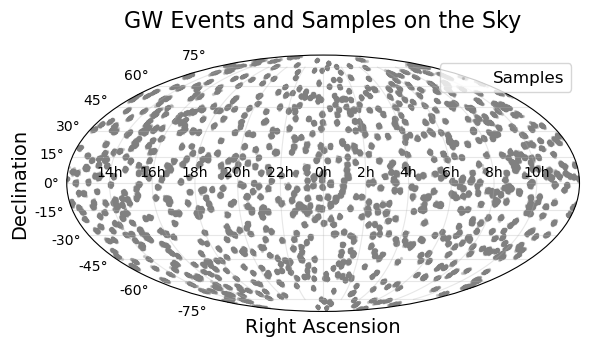

In [53]:
# Prepare data for plotting
# Flatten samples to 1D array for plotting
if ra_samples.ndim == 2:
    ra_all_samples = ra_samples.flatten()
    dec_all_samples = dec_samples.flatten()
else:
    ra_all_samples = ra_samples
    dec_all_samples = dec_samples

print(ra_all_samples.shape, dec_all_samples.shape)
# Convert RA from [0, 2π] to [-π, π] for Mollweide projection
ra_events_plot = np.where(ra_events > np.pi, ra_events - 2*np.pi, ra_events)
ra_all_samples_plot = np.where(ra_all_samples > np.pi, ra_all_samples - 2*np.pi, ra_all_samples)

# Plot scatter plot of GW events and samples on the sky with Mollweide projection
figsize = (6, 4)
fig, ax = plt.subplots(figsize=figsize, subplot_kw={'projection': 'mollweide'})

# Plot all samples as small points
ax.scatter(ra_all_samples_plot, dec_all_samples, c='gray', s=2, alpha=0.3, 
           label='Samples', rasterized=True)

# # Plot GW events as big stars
# ax.scatter(ra_events_plot, dec_events, c='magenta', s=20, marker='*', 
#            edgecolors=None, linewidths=0.5, label='GW Events', zorder=10)

ax.set_xlabel('Right Ascension', fontsize=14)
ax.set_ylabel('Declination', fontsize=14)
ax.set_title('GW Events and Samples on the Sky', fontsize=16, pad=20)
ax.legend(fontsize=12, loc='upper right')
ax.grid(True, alpha=0.3)

# Set tick labels to show hours
ax.set_xticklabels(['14h', '16h', '18h', '20h', '22h', '0h', '2h', '4h', '6h', '8h', '10h'])

plt.tight_layout()
plt.show()